## MLC HW 4

### Question 1 (40 points)

In this question, you will model traffic counts in Pittsburgh using Gaussian process (GP) regression.  The included dataset, "PittsburghTrafficCounts.csv", represents the average daily traffic counts computed by traffic sensors at over 1,100 locations in Allegheny County, PA.  The data was collected from years 2012-2014 and compiled by Carnegie Mellon University’s Traffic21 Institute; we have the longitude, latitude, and average daily count for each sensor.  

Given this dataset, your goal is to learn a model of traffic count as a function of spatial location.  To do so, fit a Gaussian Process regression model to the observed data.  While you can decide on the precise kernel specification, you should try to achieve a good model fit, as quantified by a log marginal likelihood value greater than (i.e., less negative than) -1400.  Here are some hints for getting a good model fit:

* We recommend that you take the logarithm of the traffic counts, and then subtract the mean of this vector, before fitting the model.

* Since the data is noisy, don't forget to include a noise term (WhiteKernel) in your model.

* When fitting a GP with RBF kernel on multidimensional data, you can learn a separate length scale for each dimension, e.g., length_scale=(length_scale_x, length_scale_y). 

Your Python code should provide the following five outputs:

1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

2) The log marginal likelihood of the training data. (5 pts)

3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)


In [1]:
import pandas as pd
import numpy as np
Data1=pd.read_csv("PittsburghTrafficCounts.csv")
Data1.head()

,Longitude,Latitude,AvgDailyTrafficCount
0,-80.278366,40.468606,84.0
1,-80.162117,40.384598,95.0
2,-80.221205,40.366778,97.0
3,-80.142455,40.622084,111.0
4,-80.131975,40.544915,125.0


In [2]:
from pgmpy.estimators import HillClimbSearch
from pgmpy.estimators import BicScore
from pgmpy.estimators import MaximumLikelihoodEstimator
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt

In [3]:
from sklearn.ensemble import IsolationForest
from pgmpy.models import BayesianModel

#### 1) The kernel after parameter optimization and fitting to the observed data. (10 pts)

In [4]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel,WhiteKernel

In [5]:
#normalizing data
x = Data1.iloc[:,:2]
y = np.log(Data1['AvgDailyTrafficCount']) - np.log(Data1['AvgDailyTrafficCount']).mean()
Data1['AvgDailyTrafficCount_N'] = y

In [6]:
kernel = 1.* RBF(length_scale=1., length_scale_bounds=(1e-3, 1e3)) \
    + WhiteKernel(noise_level=1., noise_level_bounds=(1e-10, 1e10))

# Fit to data
gp = GaussianProcessRegressor(kernel=kernel, random_state=1)
gp.fit(x, y)

GaussianProcessRegressor(alpha=1e-10, copy_X_train=True,
                         kernel=1**2 * RBF(length_scale=1) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=0, normalize_y=False,
                         optimizer='fmin_l_bfgs_b', random_state=1)

In [7]:
print(gp.kernel_)

0.662**2 * RBF(length_scale=0.0355) + WhiteKernel(noise_level=0.567)


#### 2) The log marginal likelihood of the training data. (5 pts)

In [8]:
print (gp.log_marginal_likelihood_value_)

-1365.946691913925


#### 3) Show a 2-D plot of the model's predictions over a mesh grid of longitude/latitude (with color corresponding to the model's predictions) and overlay a 2-D scatter plot of sensor locations (with color corresponding to the observed values). (10 pts)

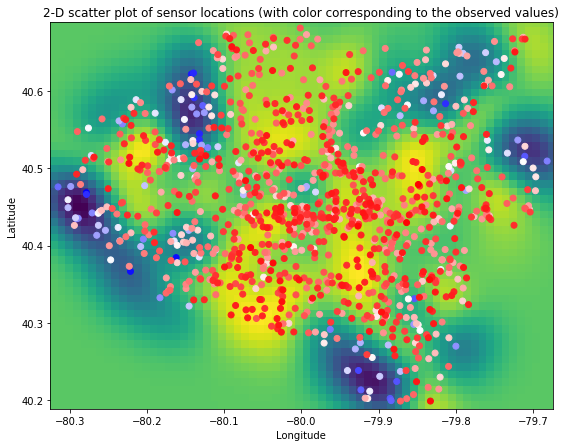

In [9]:
X = np.array(x)
y2 = np.array(y)

x_min, x_max = X[:, 0].min() - 0.01, X[:, 0].max() + 0.01
y_min, y_max = X[:, 1].min() - 0.01, X[:, 1].max() + 0.01

h = .01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(len(np.arange(y_min, y_max, h)),len(np.arange(x_min, x_max, h)))

plt.figure(figsize=(9, 9))
plt.subplot(1, 1, 1)
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

plt.scatter(X[:,0], X[:,1], c=y2, cmap='bwr')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.title("2-D scatter plot of sensor locations (with color corresponding to the observed values)")
plt.show()

#### 4) What percentage of sensors have average traffic counts more than two standard deviations higher or lower than the model predicts given their spatial location? (5 pts)

In [10]:
Data1['predict'] = gp.predict(Data1[['Longitude', 'Latitude']])

Data1['zscore'] = (Data1['AvgDailyTrafficCount_N'] - Data1['predict'].mean())/Data1['predict'].std()
outlier_val = Data1[abs((Data1['AvgDailyTrafficCount_N'] - Data1['predict'].mean())/Data1['predict'].std()) > 2.0]

percentage = 100*float(len(outlier_val)) / float(len(Data1))
print (percentage)

13.452914798206278


This is the percentage of sensors having average traffice counts more than two standard deviations higher or lower than the model prediction


#### 5) Show a 2-D scatter plot of the sensor locations, with three colors corresponding to observed values a) more than two standard deviations higher than predicted, b) more then two standard deviations lower than predicted, and c) within two standard deviations of the predicted values. (10 pts)

In [11]:
greater = Data1[Data1['zscore'] > 2.0]
smaller = Data1[Data1['zscore'] < -2.0]
within = Data1[abs(Data1['zscore']) <= 2.0]

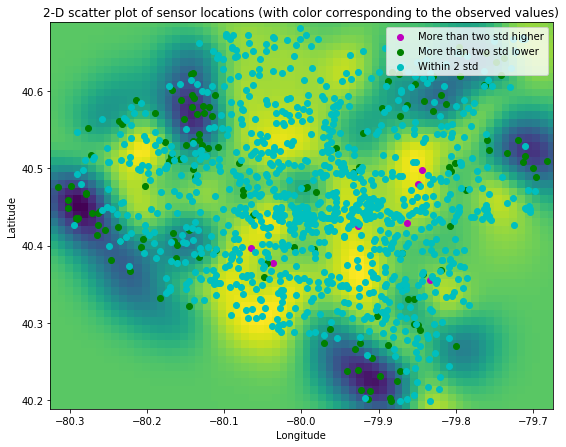

In [12]:
X = np.array(x)
y3 = np.array(y)

x_min, x_max = X[:, 0].min() - 0.01, X[:, 0].max() + 0.01
y_min, y_max = X[:, 1].min() - 0.01, X[:, 1].max() + 0.01

h = .01
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

Z = gp.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(len(np.arange(y_min, y_max, h)),len(np.arange(x_min, x_max, h)))


plt.figure(figsize=(9, 9))
plt.subplot(1, 1, 1)
plt.imshow(Z, extent=(x_min, x_max, y_min, y_max), origin="lower")

plt.scatter(greater['Longitude'], greater['Latitude'], c='m', label="More than two std higher")
plt.scatter(smaller['Longitude'], smaller['Latitude'], c='g', label="More than two std lower")
plt.scatter(within['Longitude'], within['Latitude'], c='c', label="Within 2 std")

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.legend(loc='upper right')
plt.title("2-D scatter plot of sensor locations (with color corresponding to the observed values)")
plt.show()


### Question 2: Cluster-based anomaly detection (10 points)

Given an unlabeled dataset with two real-valued attributes, we perform cluster-based anomaly detection by running k-means, choosing the number of clusters k automatically using the Schwarz criterion.  Four clusters are formed:

A: 100 points, center (0, 0), standard deviation 0.1

B: 150 points, center (35, 5), standard deviation 5

C: 2 points, center (15, 20), standard deviation 1

D: 200 points, center (10, 10), standard deviation 1

Given the four points below, which of these points are, and are not, likely to be anomalies?  Choose “Anomaly” or “Not Anomaly”, and provide a brief explanation, for each point. 
(Hint: your answers should take into account the size and standard deviation of each cluster as well as the distances to cluster centers.)

(1, 0)		Anomaly / Not Anomaly


(35, 2)		Anomaly / Not Anomaly


(15, 19)	Anomaly / Not Anomaly


(10, 11)	Anomaly / Not Anomaly


####  (1, 0) - Anomaly : It is an anomaly as the Cluster A contains 100 points and the standard deviation is very small. Hence it is a dense cluster. The point (1,0) is 10 standard deviations away from the center(0,0). Hence it is an anomaly.

#### (35,2) - Not Anomaly : It is not an anomaly. The cluster has 150 points but a large standard deviation. It is lense dense than cluster A and the point (35,2) is only 1 standard deviation away from the center and therefore not anomalous.

#### (15,19) - Anomaly : It is an anomaly as Cluster C has only 2 points.

#### (10,11) - Not Anomaly : It is not an anomaly. The cluster has 200 points and standard deviation = 1. The point (10,11) is just 1 standard deviation away from the center.

### Question 3: Anomaly detection (50 points)

For this question, use the "County Health Indicators" dataset provided to identify the most anomalous counties. Please list the top 5 most anomalous counties computed using each of the following models.  (We recommend that, as a pre-processing step, you drop na values, and make sure all numeric values are treated as floats not strings.)

Part 1: Learn a Bayesian network structure using only the six features ["'\% Smokers'","'\% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'\% Children in Poverty'","'Average Daily PM2.5'"].  Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4. 

(a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts) 

(b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)

Part 2: Cluster based anomaly detection.  Use all numeric features for this part, and do not discretize. 

(a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

(b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose.  (10 pts)

Part 4: Compare and contrast the results from the different models.  Were there some counties that were found to be anomalous in some models and not in others?  Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [13]:
Data2=pd.read_csv("2016CountyHealthIndicators.csv")
Data2.head()

,County,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
0,"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,...,18,4.3,27,13.8,254,76,12.9,14,89,42
1,"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,...,20,4.5,28,12.0,221,70,13.1,15,84,37
2,"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,...,38,5.3,54,8.1,147,64,12.6,18,84,35
3,"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,...,27,4.3,32,9.8,236,75,12.9,13,84,46
4,"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,...,24,4.1,28,8.5,219,89,12.7,12,85,59


In [14]:
Data2.set_index('County', inplace=True)
Data2 = Data2.replace('?',np.nan)
Data2.dropna(inplace=True)
Data2.head()

,'\% Reporting Fair/Poor Health','Physically Unhealthy Days Per Month','Mentally Unhealthy Days Per Month','\% Low birth weight births','\% Smokers','\% Obese','Food Environment Index','\% Physically Inactive','\% With Access To Exercise','\% Excessive Drinking',...,'\% Children in Poverty','80/20 Income Ratio','\% Single-Parent Households','Association Rate','Violent Crime Rate','Injury Death Rate','Average Daily PM2.5','\% Severe Housing Problems','\% Drive Alone','\% Long Commute - Drives Alone'
County,,,,,,,,,,,,,,,,,,,,,
"Autauga, Alabama",19,4.4,4.3,9,19,31,7.1,29,71,15,...,18,4.3,27,13.8,254,76,12.9,14,89,42
"Baldwin, Alabama",16,4.1,4.2,9,19,27,7.6,25,72,15,...,20,4.5,28,12.0,221,70,13.1,15,84,37
"Barbour, Alabama",26,4.9,4.7,12,21,41,5.1,33,45,12,...,38,5.3,54,8.1,147,64,12.6,18,84,35
"Bibb, Alabama",22,4.8,4.6,12,21,40,7.4,33,33,14,...,27,4.3,32,9.8,236,75,12.9,13,84,46
"Blount, Alabama",21,4.6,4.5,7,19,32,8.3,29,26,14,...,24,4.1,28,8.5,219,89,12.7,12,85,59


### Part1:

#### Learn a Bayesian network structure using only the six features ["'% Smokers'","'% Obese'","'Violent Crime Rate'","'80/20 Income Ratio'","'% Children in Poverty'","'Average Daily PM2.5'"]. Use pd.cut() to discretize each feature into 5 categories: 0,1,2,3,4.


#### a) Use HillClimbSearch and BicScore to learn the Bayesian network structure (5 pts)

In [15]:
df = Data2[["'\% Smokers'","'\% Obese'","'Violent Crime Rate'", "'80/20 Income Ratio'", "'\% Children in Poverty'", "'Average Daily PM2.5'"]]
ls = ['smokers', 'obese', 'violent_crime_rate', '80/20_income_ratio', 'children_poverty', 'avg_pm_2.5']
df.columns = ls
df.head()

,smokers,obese,violent_crime_rate,80/20_income_ratio,children_poverty,avg_pm_2.5
County,,,,,,
"Autauga, Alabama",19,31,254,4.3,18,12.9
"Baldwin, Alabama",19,27,221,4.5,20,13.1
"Barbour, Alabama",21,41,147,5.3,38,12.6
"Bibb, Alabama",21,40,236,4.3,27,12.9
"Blount, Alabama",19,32,219,4.1,24,12.7


In [16]:
df.iloc[:,:] = np.array(df.iloc[:,:].apply(pd.to_numeric,errors='coerce',downcast='integer'))
df.iloc[:,:] = df.iloc[:,:].apply(pd.cut, bins=5, labels=False)
df.dropna(inplace=True)
df.head()

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

,smokers,obese,violent_crime_rate,80/20_income_ratio,children_poverty,avg_pm_2.5
County,,,,,,
"Autauga, Alabama",1,2,0,1,1,3
"Baldwin, Alabama",1,2,0,1,1,3
"Barbour, Alabama",2,4,0,2,3,3
"Bibb, Alabama",2,4,0,1,2,3
"Blount, Alabama",1,2,0,1,2,3


In [17]:
df.iloc[:,:] = df.iloc[:,:].apply(pd.to_numeric,errors='coerce',downcast='integer')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [18]:
hc = HillClimbSearch(df, scoring_method=BicScore(df))
hc_model = hc.estimate()
print(hc_model.edges())

/opt/anaconda3/lib/python3.7/site-packages/pgmpy/estimators/base.py:54: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  states = sorted(list(self.data.ix[:, variable].dropna().unique()))
/opt/anaconda3/lib/python3.7/site-packages/pgmpy/estimators/base.py:116: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  state_count_data = data.ix[:, variable].value_counts()


[('smokers', 'obese'), ('smokers', 'avg_pm_2.5'), ('violent_crime_rate', 'children_poverty'), ('children_poverty', 'smokers'), ('children_poverty', '80/20_income_ratio')]


#### (b) Which 5 counties have the lowest (most negative) log-likelihood values? Please show a ranked list of the top counties' names and log-likelihood values. (10 pts)


In [19]:
# Log-likelihood of data record x given model
def LL(x,model,verbose=False):
    loglike = 0
    for cpd in model.get_cpds():
        temp_cpd = cpd.copy()
        thevariable = temp_cpd.variable
        theparents = model.predecessors(thevariable)
        for parent in theparents:
            temp_cpd.reduce([(parent, x[parent])])
        theprob = temp_cpd.get_values()[x[thevariable],0]
        if verbose:
            print (thevariable,theparents,theprob)
        loglike += np.log(theprob)
    return loglike

In [20]:
bm = BayesianModel(hc_model.edges())
bm.fit(df, estimator=MaximumLikelihoodEstimator)
df['log_likelihood']=df.apply(lambda x: LL(x, bm),axis=1)

/opt/anaconda3/lib/python3.7/site-packages/pgmpy/estimators/MLE.py:128: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  state_counts.ix[:, (state_counts == 0).all()] = 1
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [21]:
df.head()

,smokers,obese,violent_crime_rate,80/20_income_ratio,children_poverty,avg_pm_2.5,log_likelihood
County,,,,,,,
"Autauga, Alabama",1,2,0,1,1,3,-2.961528
"Baldwin, Alabama",1,2,0,1,1,3,-2.961528
"Barbour, Alabama",2,4,0,2,3,3,-7.545400
"Bibb, Alabama",2,4,0,1,2,3,-5.988829
"Blount, Alabama",1,2,0,1,2,3,-3.528275


In [31]:
#lowest (most negative) log-likelihood values
dfx = df.sort_values(by= ["log_likelihood"]).head()
dfx

,smokers,obese,violent_crime_rate,80/20_income_ratio,children_poverty,avg_pm_2.5,log_likelihood
County,,,,,,,
"New York, New York",0,0,1,4,2,2,-16.608495
"San Francisco, California",0,0,1,3,1,0,-14.827149
"Roulette, North Dakota",4,4,0,4,3,1,-14.686742
"Suffolk, Massachusetts",1,1,2,4,2,2,-14.457849
"District of Columbia, District of Columbia",1,1,3,3,2,3,-13.671439


### Part 2: Cluster based anomaly detection. Use all numeric features for this part, and do not discretize.

#### (a) Clustering with k-means. Please use k=3 clusters. Compute each record's distance to the nearest cluster center and report the five counties which have the longest distances. (10 pts)

In [23]:
Data2.iloc[:,:] = Data2.iloc[:,:].apply(pd.to_numeric,errors='coerce',downcast='integer')
Data3 = Data2.dropna()
km_df = Data3
km=KMeans(n_clusters=3,random_state=999)
score=km.fit_predict(km_df)

In [24]:
km_df2=pd.DataFrame(km.transform(km_df))
km_df2.index = km_df.index
km_df2.columns=list(range(3))
km_df2["nd"] = km_df2.min(axis=1)
km_df2['cluster'] = km_df2.idxmin(axis=1)
km_df2.sort_values(by= ["nd"], ascending=False).head(5)

,0,1,2,nd,cluster
County,,,,,
"Shannon, South Dakota",2443.716031,1970.018443,2251.260167,1970.018443,1
"St. Louis City, Missouri",2036.147297,1332.735955,1759.249198,1332.735955,1
"Crittenden, Arkansas",1917.732820,1208.900834,1639.063836,1208.900834,1
"Petersburg City, Virginia",1644.876605,1017.910163,1394.632068,1017.910163,1
"Baltimore City, Maryland",1651.954082,918.374430,1366.737248,918.374430,1


#### (b) Cluster with Gaussian Mixture. Please repeat (2)a but use log-likelihood for each record (rather than distance) as the measure of anomalousness. (10 pts)

In [25]:
gm_df = Data3
gm=GaussianMixture(n_components=3,random_state=999)
gm.fit(gm_df)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
                means_init=None, n_components=3, n_init=1, precisions_init=None,
                random_state=999, reg_covar=1e-06, tol=0.001, verbose=0,
                verbose_interval=10, warm_start=False, weights_init=None)

In [26]:
gm_df2=pd.DataFrame()
gm_df2["log_likelihood"] = gm.score_samples(gm_df)
gm_df2.index = gm_df.index
gm_df2.sort_values(by= ["log_likelihood"]).head()

,log_likelihood
County,
"Shannon, South Dakota",-197.420106
"Apache, Arizona",-133.042814
"New York, New York",-131.452092
"Willacy, Texas",-129.450559
"Roulette, North Dakota",-126.696033


### Part 3: Choose one more anomaly detection model you prefer and report the top 5 most anomalous counties by the model you chose. (10 pts)

In [27]:
# Using anomaly detection model = Local outlier factor (LOF)

from sklearn.neighbors import LocalOutlierFactor

lof_df = Data3

# fit the model
lof = LocalOutlierFactor(n_neighbors=20, novelty=True)
lof.fit(lof_df)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/neighbors/lof.py:236: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


LocalOutlierFactor(algorithm='auto', contamination='legacy', leaf_size=30,
                   metric='minkowski', metric_params=None, n_jobs=None,
                   n_neighbors=20, novelty=True, p=2)

In [28]:
# top 5 most anomalous counties

lof_df2 = pd.DataFrame()
lof_df2['score'] = lof.decision_function(lof_df)
lof_df2.index = lof_df.index
lof_df2.sort_values(by= ["score"]).head()

,score
County,
"Shannon, South Dakota",-3.368267
"St. Louis City, Missouri",-1.340163
"Crittenden, Arkansas",-1.049323
"Nicholas, West Virginia",-0.966623
"Petersburg City, Virginia",-0.875938


### Part 4: Compare and contrast the results from the different models. Were there some counties that were found to be anomalous in some models and not in others? Please provide some intuitions on why each county was found to be anomalous. (5 pts)

In [29]:
#res_cbn = pd.DataFrame()
kmc = pd.DataFrame(km_df2.sort_values(by= ["nd"], ascending=False).head().index)
kmc['km'] = "Anomalous"
gmc = pd.DataFrame(gm_df2.sort_values(by= ["log_likelihood"]).head().index)
gmc['gm'] = "Anomalous"
lofc = pd.DataFrame(lof_df2.sort_values(by= ["score"]).head().index)
lofc['lof'] = "Anomalous"
total = pd.merge(kmc,gmc,how='outer')
total = pd.merge(lofc,total,how='outer')

In [30]:
total


,County,lof,km,gm
0,"Shannon, South Dakota",Anomalous,Anomalous,Anomalous
1,"St. Louis City, Missouri",Anomalous,Anomalous,NaN
2,"Crittenden, Arkansas",Anomalous,Anomalous,NaN
3,"Nicholas, West Virginia",Anomalous,NaN,NaN
4,"Petersburg City, Virginia",Anomalous,Anomalous,NaN
5,"Baltimore City, Maryland",NaN,Anomalous,NaN
6,"Apache, Arizona",NaN,NaN,Anomalous
7,"New York, New York",NaN,NaN,Anomalous
8,"Willacy, Texas",NaN,NaN,Anomalous
9,"Roulette, North Dakota",NaN,NaN,Anomalous


From our results we can see that Shannon, South Dakota is anomalous as per all 3 models. Shannon has a very high death rate and after looking into more detail I found that it is also called as the deadliest county in America

St. Louis City, Crittenden and Petersburg City are detected as anomalous according to LOF, K Means. These all have very high crime stats

Apache, New York, Willacy and Roulette are detected as anomalous according to Gaussian Mixture. They also have very high crime stats

Nicholas, West Virginia is detected as anomalous according to LOF